# The backpropagation and training of neural networks tutorial by Andrej Karpathy(https://www.youtube.com/watch?v=VMj-3S1tku0&t=1678s)



In [31]:
import math
import numpy as np
import pandas as pd
from graphviz import Digraph
import matplotlib.pyplot as plt
%matplotlib inline

In [233]:
class Value: 
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data + other.data, (self, other), '+')

        def _backward(): 
            self.grad += 1.0 * result.grad
            other.grad += 1.0 * result.grad
        result._backward = _backward
        
        return result

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * result.grad
            other.grad += self.data * result.grad
        result._backward = _backward
        
        return result

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        result = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * result.grad
        result._backward = _backward
        return result    
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self +(-other)

    def __radd__(self, other):
        return self + other
    
    def tanh(self):
        n = self.data
        tan = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        result = Value(tan, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - tan**2) * result.grad
        result._backward = _backward
        return result 

    def exp(self):
        x = self.data
        result = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += result.data * result.grad
        result._backward = _backward
        return result

    def backward(self):        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [234]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [222]:
a = Value(2.0, label='a')
sum((a, a))

TypeError: unsupported operand type(s) for +: 'int' and 'Value'

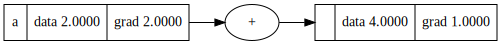

In [210]:
c.backward()
draw_dot(c)

In [269]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [270]:
a._backward

<function __main__.Value.__init__.<locals>.<lambda>()>

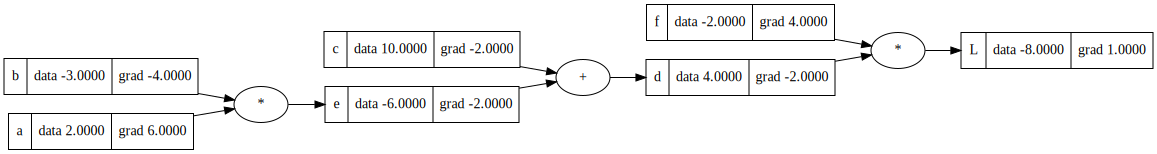

In [271]:
L.grad = 1
f.grad = 4
d.grad = -2
c.grad = -2
e.grad = -2
a.grad = 6
b.grad = -4
draw_dot(L)


In [272]:
# dL / dL = 1
# dL / df = 4
# dL / dd = -2
# dd / dc = 1
# dd / de = 1
# dL / de = dL/dd * dd/de = -2
# dL / dc = dL/dd * dd/dc = -2 *  
# dL / da = dL/de * de/da = -2 * -3 = 6
# dL / db = dL/de * de/db = -2 * 2 = -4

In [273]:
def demo():
    delta = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    a = Value(2.0, label='a')
    b = Value(-3.0 + delta, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    return((L2 - L1)/delta)

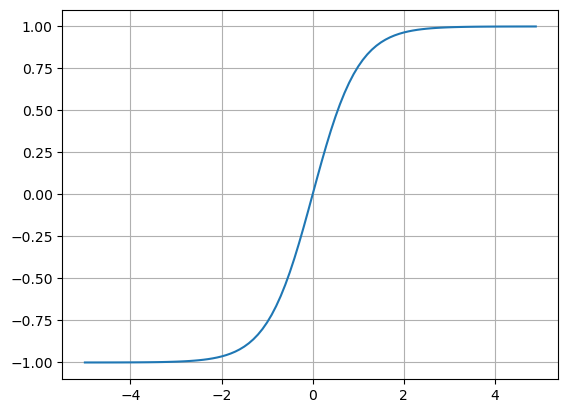

In [274]:
plt.plot(np.arange(-5, 5, 0.1), np.tanh(np.arange(-5, 5, 0.1)))
plt.grid()

In [275]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

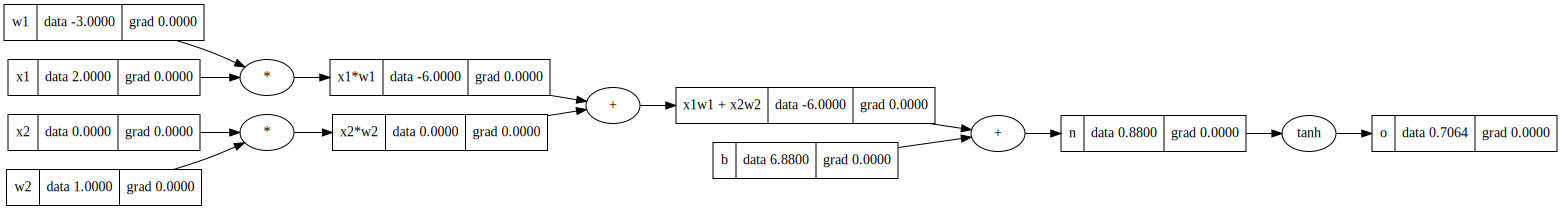

In [276]:
draw_dot(o)

In [197]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

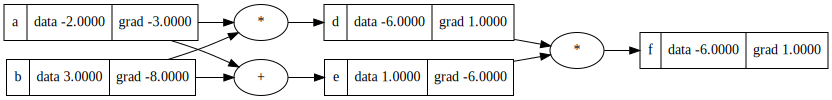

In [198]:
f.backward()
draw_dot(f)

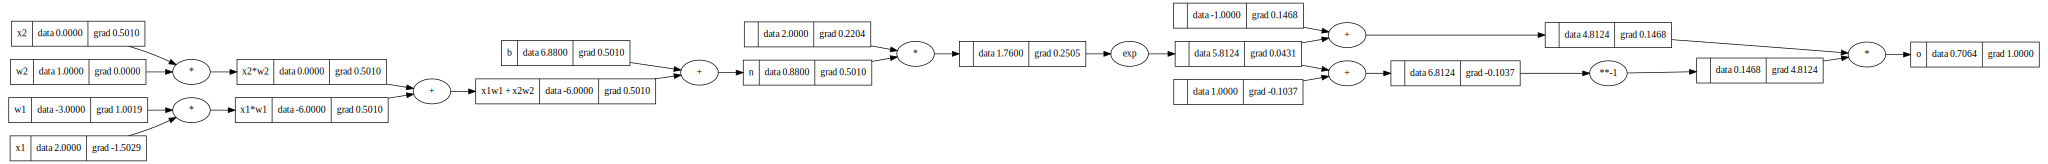

In [277]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()
draw_dot(o)

In [4]:
import torch

In [15]:
x1 = torch.Tensor([2.0]).double() ; x1.require_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.require_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.require_grad = True
w2 = torch.Tensor([1.0]).double(); w2.require_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

0.7071066904050358


In [265]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

In [266]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [267]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [269]:
nn = MLP(3, [4,4,1])

In [287]:
nn.layers[0].neurons[0].parameters()

[Value(data=-0.3887425012063914),
 Value(data=0.7592010395009685),
 Value(data=-0.7448690102791511),
 Value(data=0.7300862222273643)]

In [289]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [290]:
ypred = [nn(x) for x in xs]

In [291]:
loss = sum((y1 - y2)**2 for y1, y2 in zip(ypred, ys))

In [292]:
loss

Value(data=4.949502068480568)

In [293]:
loss.backward()

In [297]:
nn.layers[0].neurons[0].w[0].grad

0.4572992137244575

In [298]:
nn.layers[0].neurons[0].w[0].data

-0.3887425012063914